# Data
https://paperswithcode.com/dataset/citeseer

In [1]:
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt

dataset = Planetoid(root=".", name="CiteSeer")

print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Has isolated nodes: {dataset[0].has_isolated_nodes()}')

Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6
Has isolated nodes: True


In [16]:
data = dataset[0]
print(data.edge_index)

tensor([[   0,    1,    1,  ..., 3324, 3325, 3326],
        [ 628,  158,  486,  ..., 2820, 1643,   33]])


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


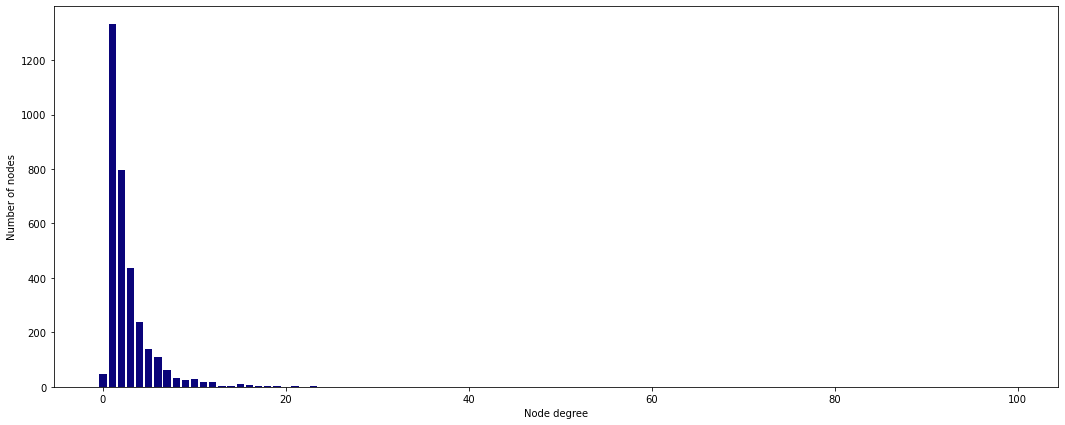

In [2]:
from torch_geometric.utils import degree
from collections import Counter

degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)
print(data)

fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')
plt.show()

# GCN Model

In [3]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

In [4]:
class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)
  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

# Helper

In [5]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

In [6]:
def train(model, data):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()

        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

In [7]:
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [8]:
%%time

gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

train(gcn, data)

acc = test(gcn, data)
print(f'GCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.802 | Train Acc:  16.67% | Val Loss: 1.80 | Val Acc: 13.60%
Epoch  10 | Train Loss: 0.580 | Train Acc:  87.50% | Val Loss: 1.31 | Val Acc: 55.60%
Epoch  20 | Train Loss: 0.188 | Train Acc:  96.67% | Val Loss: 1.29 | Val Acc: 56.80%
Epoch  30 | Train Loss: 0.093 | Train Acc:  96.67% | Val Loss: 1.49 | Val Acc: 57.20%
Epoch  40 | Train Loss: 0.060 | Train Acc:  99.17% | Val Loss: 1.62 | Val Acc: 54.00%
Epoch  50 | Train Loss: 0.074 | Train Acc:  97.50% | Val Loss: 1.47 | Val Acc: 58.00%
Epoch  60 | Train Loss: 0.051 | Train Acc:  99.17% | Val Loss: 1.58 | Val Acc: 57.20%
Epoch  70 | Train Loss: 0.039 | Train Acc: 100.00% | Val Loss: 1.48 | Val Acc: 57.00%
Epoch  80 | Train Loss: 0.066 | Train Acc:  98.33% | Val Loss: 1.56 | Val Acc: 55.80%
Epoch  90 | Train Loss: 0.063 | Train Acc:  99.17% | Val Loss: 1.66 | Val Acc: 56.60%
Epoch 100 | Train Loss: 0.046 | Train Acc: 100.00% | Val Loss: 1.53 | Val Acc: 5

# GAT Model

In [9]:
%%time

gat = GAT(dataset.num_features, 16, dataset.num_classes)
print(gat)

train(gat, data)

acc = test(gat, data)
print(f'GAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 16, heads=8)
  (gat2): GATv2Conv(128, 6, heads=1)
)
Epoch   0 | Train Loss: 1.776 | Train Acc:  24.17% | Val Loss: 1.79 | Val Acc: 22.80%
Epoch  10 | Train Loss: 0.011 | Train Acc:  99.17% | Val Loss: 1.36 | Val Acc: 66.40%
Epoch  20 | Train Loss: 0.024 | Train Acc:  99.17% | Val Loss: 1.49 | Val Acc: 65.20%
Epoch  30 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.38 | Val Acc: 65.40%
Epoch  40 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.16 | Val Acc: 67.00%
Epoch  50 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.08 | Val Acc: 69.00%
Epoch  60 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.01 | Val Acc: 68.80%
Epoch  70 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.04 | Val Acc: 69.20%
Epoch  80 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.03 | Val Acc: 70.00%
Epoch  90 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.06 | Val Acc: 71.00%
Epoch 100 | Train Loss: 0.004 | Train Acc: 100.00% | Val 

# Learned vs Unlearned

C:\Users\giang\.conda\envs\pygeo\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[[-18.582155   19.74775  ]
 [ 24.714478   27.504585 ]
 [-13.195764  -42.141376 ]
 ...
 [ -3.7756672 -27.445858 ]
 [  9.1424465 -19.89496  ]
 [ 14.623843   -6.564481 ]]


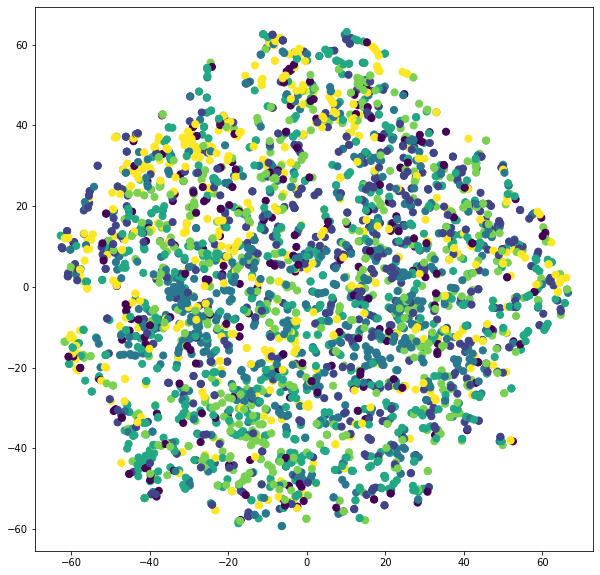

In [10]:
from sklearn.manifold import TSNE
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

print(tsne)
# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('on')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

C:\Users\giang\.conda\envs\pygeo\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


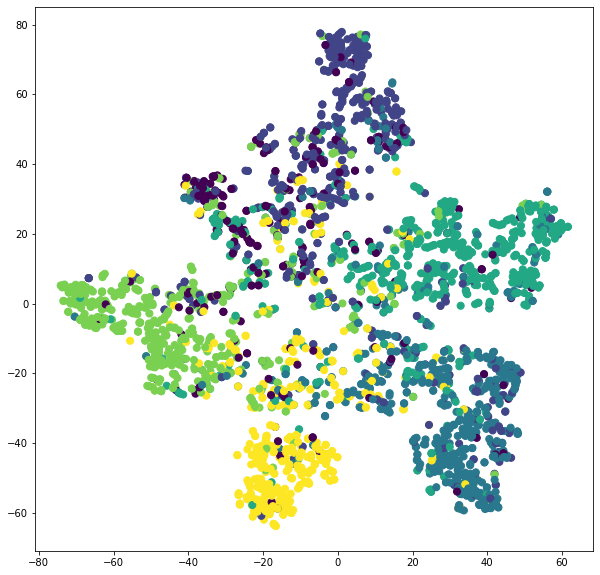

In [11]:
node_embeds, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca')

embeds = tsne.fit_transform(node_embeds.detach())
# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('on')
plt.scatter(embeds[:, 0], embeds[:, 1], s=50, c=data.y)
plt.show()

In [64]:
print(data.x.shape)

torch.Size([3327, 3703])


In [65]:
print(node_embeds.shape)

torch.Size([3327, 6])


In [58]:
print(embeds.shape)

(3327, 2)


In [67]:
print(embeds)

[[-35.001232 -51.918877]
 [-10.190118  68.890625]
 [ 33.74436  -57.563747]
 ...
 [-40.933052 -20.625183]
 [-14.797223  27.45794 ]
 [ 36.446327 -57.733974]]
